In [2]:
import pandas as pd

In [4]:
df_filtered = pd.read_csv('2023-24 Advanced Stats.xlsx - Sheet1.csv')
df_filtered = df_filtered[df_filtered['MP'] >= 1500]

In [71]:
df_filtered.columns

Index(['Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr',
       'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
       'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Awards',
       'Player-additional', 'DPOY Score', 'PF'],
      dtype='object')

In [6]:
defensive_features = ['STL%', 'BLK%', 'DRB%', 'DBPM', 'DWS']

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [10]:
from sklearn.decomposition import PCA

# Standardize the features before applying PCA
X_pca = scaler.fit_transform(df_filtered[defensive_features])

# Apply PCA
pca = PCA(n_components=len(defensive_features))
pca.fit(X_pca)

# Get explained variance ratio (importance of each principal component)
explained_variance = pca.explained_variance_ratio_

# Get feature weights for each principal component
feature_weights = pd.DataFrame(pca.components_.T, index=defensive_features, columns=[f'PC{i+1}' for i in range(len(defensive_features))])

# Add explained variance as a new row
feature_weights.loc['Explained Variance'] = explained_variance

# Display feature weights
feature_weights

,PC1,PC2,PC3,PC4,PC5
STL%,0.225701,0.781540,0.191489,-0.449429,0.315594
BLK%,0.450033,-0.295403,0.811738,0.166198,0.153840
DRB%,0.421709,-0.490986,-0.285954,-0.700920,0.089638
DBPM,0.543165,0.237749,-0.082704,0.092240,-0.795675
DWS,0.523128,0.065879,-0.464546,0.520187,0.485386
Explained Variance,0.557514,0.247724,0.095386,0.067327,0.032049


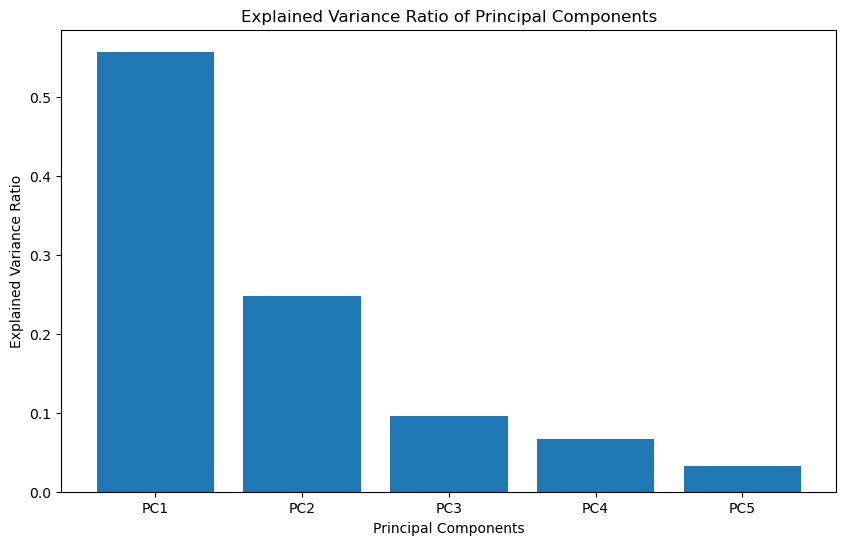

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming `feature_weights` dataframe is already computed

# Extracting explained variance and feature contributions
explained_variance = feature_weights.loc['Explained Variance'].values
num_components = len(explained_variance)

# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, num_components + 1), explained_variance, tick_label=[f'PC{i}' for i in range(1, num_components + 1)])
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()

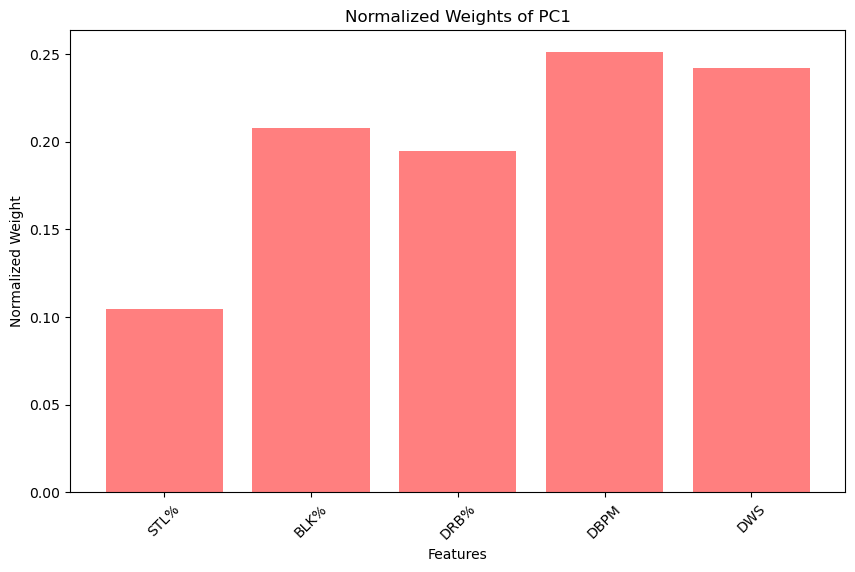

In [32]:
# Extract PC1 values
pc1_values = feature_weights['PC1'][:-1]  # Exclude the 'Explained Variance' row

# Normalize weights so they sum to 1
normalized_weights = pc1_values / pc1_values.sum()

# Display normalized weights
normalized_weights_df = pd.DataFrame({'Feature': defensive_features, 'Normalized Weight': normalized_weights.values})
normalized_weights_df

# Plot the normalized weights of PC1
plt.figure(figsize=(10, 6))
plt.bar(normalized_weights_df['Feature'], normalized_weights_df['Normalized Weight'], align='center', color = 'red', alpha = 0.5)
plt.xlabel('Features')
plt.ylabel('Normalized Weight')
plt.title('Normalized Weights of PC1')
plt.xticks(rotation=45)
plt.show()


In [36]:
# Compute the DPOY Score for each player
df_filtered['DPOY Score'] = (
    normalized_weights['DWS'] * df_filtered['DWS'] +
    normalized_weights['DBPM'] * df_filtered['DBPM'] +
    normalized_weights['STL%'] * df_filtered['STL%'] +
    normalized_weights['BLK%'] * df_filtered['BLK%'] +
    normalized_weights['DRB%'] * df_filtered['DRB%']
)

# Rank players based on the DPOY Score
df_dpoy_ranked = df_filtered[['Player', 'Team', 'MP', 'DPOY Score']].sort_values(by='DPOY Score', ascending=False)

# Display the top defensive players based on DPOY Score
df_filtered.sort_values(by = 'DPOY Score', ascending = False)[['Player', 'DPOY Score']].head(10)

,Player,DPOY Score
5,Victor Wembanyama,10.164086
24,Rudy Gobert,8.768308
14,Nikola Jokić,8.701754
104,Jusuf Nurkić,8.529528
19,Anthony Davis,8.431135
7,Domantas Sabonis,8.301934
100,Nic Claxton,7.875213
126,Jonas Valančiūnas,7.650307
4,Chet Holmgren,7.575553
20,Bam Adebayo,7.525993


In [43]:
df_new_stats = pd.read_csv("newStats.csv")

In [45]:
df_new_stats.columns

Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Trp-Dbl', 'Awards', 'Player-additional'],
      dtype='object')

In [47]:
# Ensure Personal Fouls (PF) is available in the main dataset
df_filtered = df_filtered.merge(df_new_stats[['Player', 'PF']], on='Player', how='left')

# Normalize PF and assign a negative weight (penalty for excessive fouling)
df_filtered['PF'] = scaler.fit_transform(df_filtered[['PF']])  # Standardize PF

# Adjust the DPOY formula by subtracting a penalty for PF
pf_penalty_weight = 0.10  # Assign 10% weight as a penalty for fouls

df_filtered['DPOY Score'] = (
    normalized_weights['DWS'] * df_filtered['DWS'] +
    normalized_weights['DBPM'] * df_filtered['DBPM'] +
    normalized_weights['STL%'] * df_filtered['STL%'] +
    normalized_weights['BLK%'] * df_filtered['BLK%'] +
    normalized_weights['DRB%'] * df_filtered['DRB%'] -  # Keeping DRB% for defensive rebounding
    pf_penalty_weight * df_filtered['PF']  # Subtracting the foul penalty
)

# Rank players again based on the updated DPOY Score
df_dpoy_ranked = df_filtered[['Player', 'Team', 'MP', 'DPOY Score']].sort_values(by='DPOY Score', ascending=False)

# Display the updated rankings with foul penalty applied
df_dpoy_ranked.head(10)

,Player,Team,MP,DPOY Score
4,Victor Wembanyama,SAS,2106,10.134896
13,Nikola Jokić,DEN,2737,8.589212
23,Rudy Gobert,MIN,2593,8.566316
18,Anthony Davis,LAL,2700,8.353154
110,Jusuf Nurkić,PHO,2078,8.295008
6,Domantas Sabonis,SAC,2928,8.075546
106,Nic Claxton,BRK,2116,7.801298
138,Jonas Valančiūnas,NOP,1925,7.488974
19,Bam Adebayo,MIA,2416,7.484605
3,Chet Holmgren,OKC,2413,7.456912


In [55]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

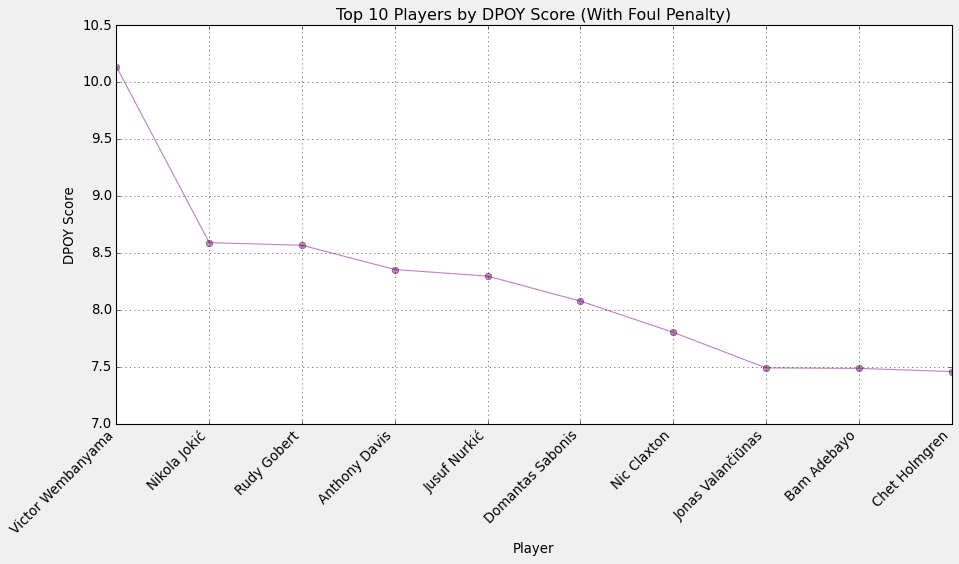

In [65]:
# Generate a line plot for DPOY scores of the top 10 players
plt.figure(figsize=(12, 6))
plt.style.use('classic')
plt.plot(df_dpoy_ranked['Player'][:10], df_dpoy_ranked['DPOY Score'][:10], marker='o', linestyle='-', color='purple', alpha = 0.5)
plt.xlabel('Player')
plt.ylabel('DPOY Score')
plt.title('Top 10 Players by DPOY Score (With Foul Penalty)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()
